In [136]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
import json

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import warnings
warnings.filterwarnings('ignore')

## Filter News Articles

### Details of Filtering Step
We explore our data in detail to find out which range of data we would like to use to train our models. Our dataset contains news articles for the past 15 years from various sources, but we initially look at the years 2015, 2016, and 2017, because these three years contain the majority of the articles inside the dataset.
<br>
The data for this range is split randomly between a few different files, so we want to combine them together and then organize the data into discrete whiles by month and year.

In [2]:
import pandas as pd

##### Filter out articles that are not within or around our dates of interest.

In [4]:
articles_df = pd.DataFrame(columns=['title', 'publication', 'date', 'year', 'month', 'content'])
for name in  ['articles1.csv', 'articles1.csv', 'articles1.csv']:
    temp_df = pd.read_csv('data/raw/all-the-news/{article_name}'.format(article_name=name))
    temp_df = temp_df[['title', 'publication', 'date', 'year', 'month', 'content']]
    temp_df = temp_df.where((temp_df.year == 2015.0) | (temp_df.year == 2016.0) | (temp_df.year == 2017.0)).dropna()
    articles_df = pd.concat([articles_df, temp_df])

##### Add a day field because we will be needing this information late in the preprocessing steps

In [5]:
articles_df = articles_df[['title', 'publication', 'date', 'year', 'month', 'content']]
articles_df['day'] = articles_df.apply(lambda row: float(row.date[-2:]), axis=1)

In [12]:
for year in range(2015, 2017+1):
    for month in range(1, 12+1):
        file_name = 'data/filtered/all-the-news/articles_{year}_{month:02}.csv'.format(year=year, month=month)
        temp_df = articles_df.where((articles_df.year == year) & (articles_df.month == month)).dropna().drop_duplicates(subset=['title'])
        if len(temp_df) != 0:
            temp_df.to_csv(file_name, index=False)

##### Plot of numbers of articles for every month from 2015 to 2017

Our results show that there is a significant number of articles for each month of 2016. There is at least 1500 articles from January to Decemeber in 2016.
<br>
We choose to use our dataset within 2016 to build our model because it has data for the entire year of 2016.

In [65]:
filtered_df = pd.DataFrame(columns=['title', 'publication', 'date', 'year', 'month', 'content'])
for year in range(2015, 2017+1):
    for month in range(1, 12+1):
        file_name = 'data/filtered/all-the-news/articles_{year}_{month:02}.csv'.format(year=year, month=month)
        temp_df = pd.read_csv(file_name)
        filtered_df = pd.concat([filtered_df, temp_df])
filtered_df['YYYY_MM'] = filtered_df.apply(lambda row: row.date[:7], axis=1)

In [111]:
count_articles_df = filtered_df.YYYY_MM.value_counts().to_frame().sort_index()

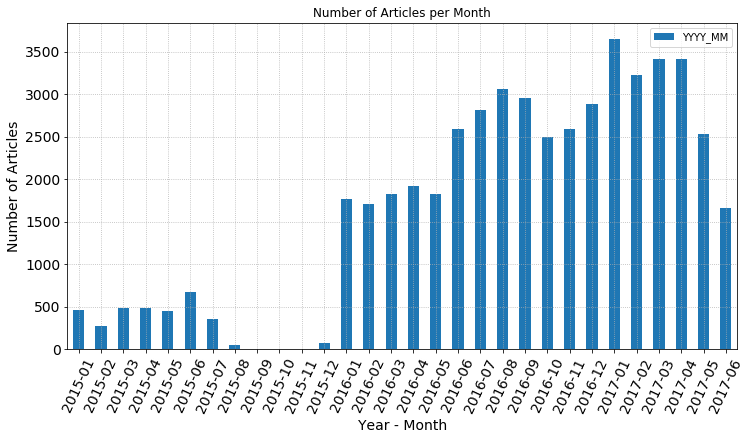

In [127]:
fig, axes = plt.subplots(nrows=1, ncols=1, sharex=False, sharey=False)
fig.set_size_inches(12, 6)
fig.subplots_adjust(hspace=.5)

count_articles_plot_args = {
    'kind' : 'bar',
    'fontsize' : 14,
    'title' : 'Number of Articles per Month',
    'ax' : axes,
    'rot' : 65
}

count_articles_plot = count_articles_df.plot(**count_articles_plot_args)
count_articles_plot.set_ylabel('Number of Articles', fontsize=14)
count_articles_plot.set_xlabel('Year - Month', fontsize=14)
count_articles_plot.grid('on', which='both', linestyle=':')

## Sentiment (Subjectivity, Polarity) and<br>TFIDF (Term Frequency-Inverse Document Frequency)<br>of News Articles

### Details of TFIDF and Sentiment Analysis Step

### Sentiment:
We analyze the sentiment of the content of each article. We want to do this because we want to use the sentiment in our stock prediction machine learning or deep learning model and see if the sentiment of popular news articles affect stock prices. The sentiment that we analyze from each article involves two parts. 
<br>
<br>
Part one of the sentiment is the subjectivity, and part two is the polarity.
<br>
Polarity scores range from -1.0 to 1.0
Sentiment scores from range 0.0 to 1.0
<br>
<br>
##### Subjectivity:
The subjectivity is the expression of personal views or beliefs, and it indicates whether a text has sentiment or not. A higher subjectivity score indicates a more subjective text, and a lower subjectivity score indicates a more objective text.
<br>
<br>
##### Polarity:
The polarity score indicates the emotions expressed, and is closely related to the type of sentiment. A higher polarity score indicates a more positive text, and a lower polarity score indicates a more negative text. Also, a polarity score of 0 indicates neutrality.

### TFIDF:
We analyze the TFIDF of each article and take a maximum of 30 words from each article with the largest TFIDF score. We use the words with the top TFIDF score in each article to find the cosine similarity to a given set of keywords. Analyzing the TFIDF of the articles will give us a more accurate indication of how related an article is to the a set of key words to that give, i.e. key words could be ('technology', 'phone', 'internet', 'security'). The example set ofkeywords will allow us to find articles that relate to technology companies and find the accurate sentiment from news articles about these companies.

In [17]:
import os
import math
import json
import pandas as pd
import pyspark
from pyspark import SparkContext
from textblob import TextBlob as tb

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/willc97/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [29]:
def tf(word, blob):
    return blob.words.count(word) / len(blob.words)

def n_containing(word, bloblist):
    return sum(1 for blob in bloblist if word in blob)

def idf(word, bloblist):
    return math.log(len(bloblist) / (1 + n_containing(word, bloblist)))

def tfidf(word, blob, bloblist):
    return tf(word, blob) * idf(word, bloblist)
    
def strtolower(s):
    return s.lower()

def analyze_news_articles(args):
    input_folder, output_folder, articles_name = args
    articles = os.path.join(input_folder, articles_name)
    
    month_df = pd.read_csv(articles)
#     print("Analyzing {name} which has {num_articles} articles".format(name=articles_name, num_articles=len(month_df)))
    
    results = dict()
    results['data'] = list()
    
    for day in range(1, 31+1):
        day_df = month_df.where(month_df.day == day).dropna()
        if len(day_df) == 0:
            continue 
#         print("Day {day}: {num_articles} articles".format(day=day, num_articles=len(day_df)))
        titles = list(day_df.title)
        years = list(day_df.year)
        months = list(day_df.month)
        contents = list(day_df.content)
        bloblist = list(map(tb, list(map(strtolower, contents))))
        
        results['year'] = years[0]
        results['month'] = months[0]
        
        for i, blob in enumerate(bloblist):
            scores = {word: tfidf(word, blob, bloblist) for word in blob.words}
            sorted_words = sorted(scores.items(), key=lambda x: x[1], reverse=True)

            result = dict()
            result['title'] = titles[i]
            result['year'] = years[i]
            result['month'] = months[i]
            result['day'] = day

            sentiment = tb(contents[i]).sentiment
            result['polarity'] = sentiment.polarity
            result['subjectivity'] = sentiment.subjectivity
            
            num_dist_words = len(sorted_words)
            result['tdidf'] = sorted_words[:min(30, num_dist_words)]

            results['data'].append(result)
    
    output_name = os.path.join(output_folder, articles_name.replace('.csv', '.json'))
        
    with open(output_name, 'w') as outfile:
        json.dump(results, outfile)
        
    return (output_name, len(results['data']))

In [129]:
input_folder = 'data/filtered/all-the-news/'
output_folder = 'data/tfidf/all-the-news/'
articles_names = os.listdir(input_folder)
arguments = [(input_folder, output_folder, articles_name) for articles_name in articles_names]

In [30]:
print('Starting analysis')
sc = pyspark.SparkContext(appName='News Articles')
process_tdidf_by_month = sc.parallelize(arguments, len(arguments)).map(analyze_news_articles)
collect_tdidf_by_month = process_tdidf_by_month.collect()
sc.stop()
print('Finished analysis')

Starting analysis
Finished analysis


### Analysis of Sentiments
<br>
We look at the analyze the polarity and sentiment scores for each given month from 2015 to 2017. In the boxplots below, we see that the mean subjectivity and polarity scores stay nearly the same across all the months, apart from the couple months in 2015 where we do not have enough data.

In [246]:
def retrieve_tfidf_sentiment(args):
    input_folder, output_folder, articles_name = args
    articles_path = os.path.join(output_folder, articles_name.replace('.csv', '.json'))
    
    with open(articles_path) as f:
        month = json.load(f)
    
    month_df = pd.DataFrame()
    
    for day in month['data']:
        day['tdidf'] = len(day['tdidf'])

        for key, value in day.items():
            day[key] = [value]
            
        day['YYYY_MM'] = '{YYYY:04}-{MM:02}'.format(YYYY=int(month['year']), MM=int(month['month']))
        
        day_df = pd.DataFrame.from_dict(day)
        month_df = month_df.append(day_df)
        
    return month_df

In [247]:
tfidf_sentiment_df = pd.DataFrame()
temp_dfs = list()

for argument in arguments:
    temp_dfs.append(retrieve_tfidf_sentiment(argument))

In [398]:
tfidf_sentiment_df = pd.concat(temp_dfs).reset_index(drop=True)

sentiment_polarity = tfidf_sentiment_df.drop(columns=['title', 'year', 'month', 
                                                      'day', 'tdidf', 'subjectivity'])
sentiment_subjectivity = tfidf_sentiment_df.drop(columns=['title', 'year', 'month', 
                                                      'day', 'tdidf', 'polarity'])

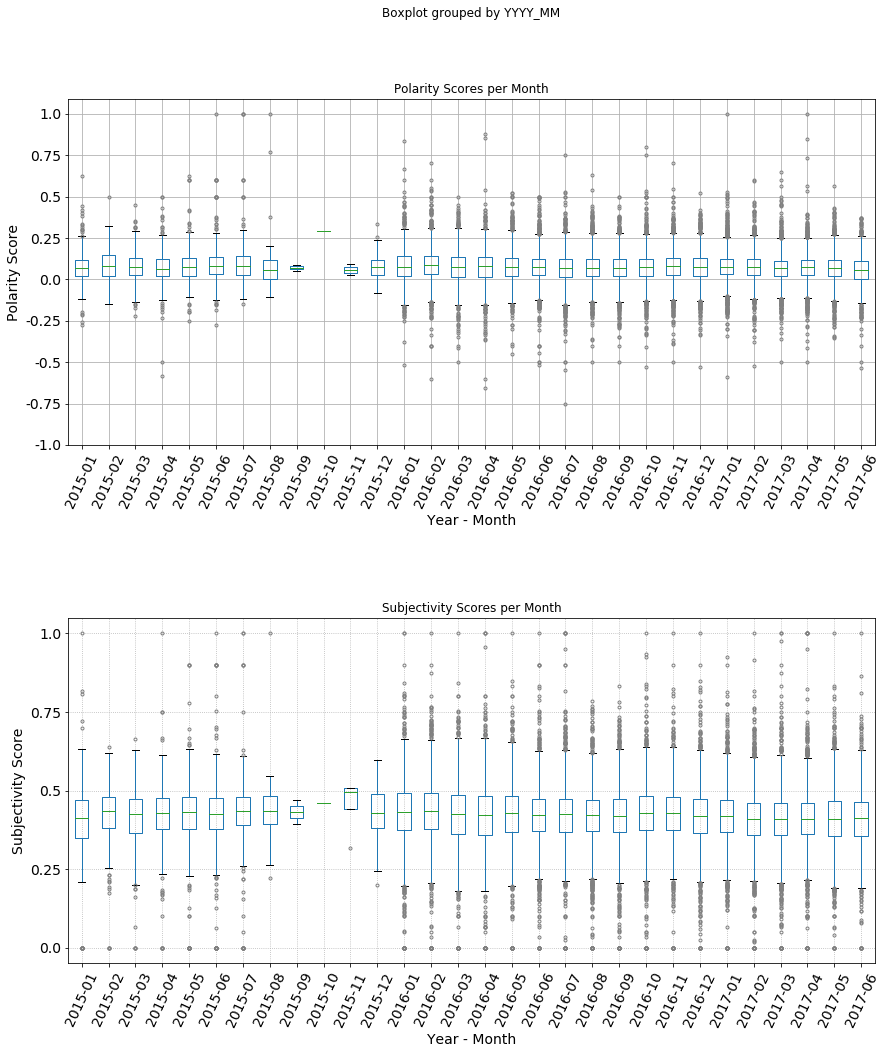

In [444]:
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=False, sharey=False)
fig.set_size_inches(14, 16)
fig.subplots_adjust(hspace=.5)

yticks = [x / 100 for x in range(-100, 110, 25)]
yticklabels = [str(ytick) for ytick in yticks]

flierprops = dict(marker='o', markerfacecolor='none', markersize=3,
                  linestyle='none', markeredgecolor='grey')

sentiment_polarity_plot_args = {
    'fontsize' : 14,
    'ax' : axes[0],
    'rot' : 65,
    'by' : 'YYYY_MM',
    'flierprops' : flierprops,
}

sentiment_subjectivity_plot_args = {
    'fontsize' : 14,
    'ax' : axes[1],
    'rot' : 65,
    'by' : 'YYYY_MM',
    'flierprops' : flierprops,
}

sentiment_polarity_plot = sentiment_polarity.boxplot(**sentiment_polarity_plot_args)
# sentiment_polarity_plot = sentiment_polarity.boxplot(by='YYYY_MM', column=['polarity'])
sentiment_polarity_plot.set_title('Polarity Scores per Month')
sentiment_polarity_plot.set_xlabel('Year - Month', fontsize=14)
sentiment_polarity_plot.set_ylabel('Polarity Score', fontsize=14)
sentiment_polarity_plot.set_yticks([x / 100 for x in range(-100, 110, 25)])
sentiment_polarity_plot.set_yticklabels([str(x / 100) for x in range(-100, 110, 25)], fontsize=14)
# sentiment_polarity_plot.grid('on', which='both', linestyle=':')

sentiment_subjectivity_plot = sentiment_subjectivity.boxplot(**sentiment_subjectivity_plot_args)
sentiment_subjectivity_plot.set_title('Subjectivity Scores per Month')
sentiment_subjectivity_plot.set_xlabel('Year - Month', fontsize=14)
sentiment_subjectivity_plot.set_ylabel('Subjectivity Score', fontsize=14)
sentiment_subjectivity_plot.set_yticks([x / 100 for x in range(0, 110, 25)])
sentiment_subjectivity_plot.set_yticklabels([str(x / 100) for x in range(0, 110, 25)], fontsize=14)
sentiment_subjectivity_plot.grid('on', which='both', linestyle=':')


# sentiment_boxplot  sentiment_boxplot.boxplot(by='YYYY_MM', column=['polarity', 'subjectivity'])

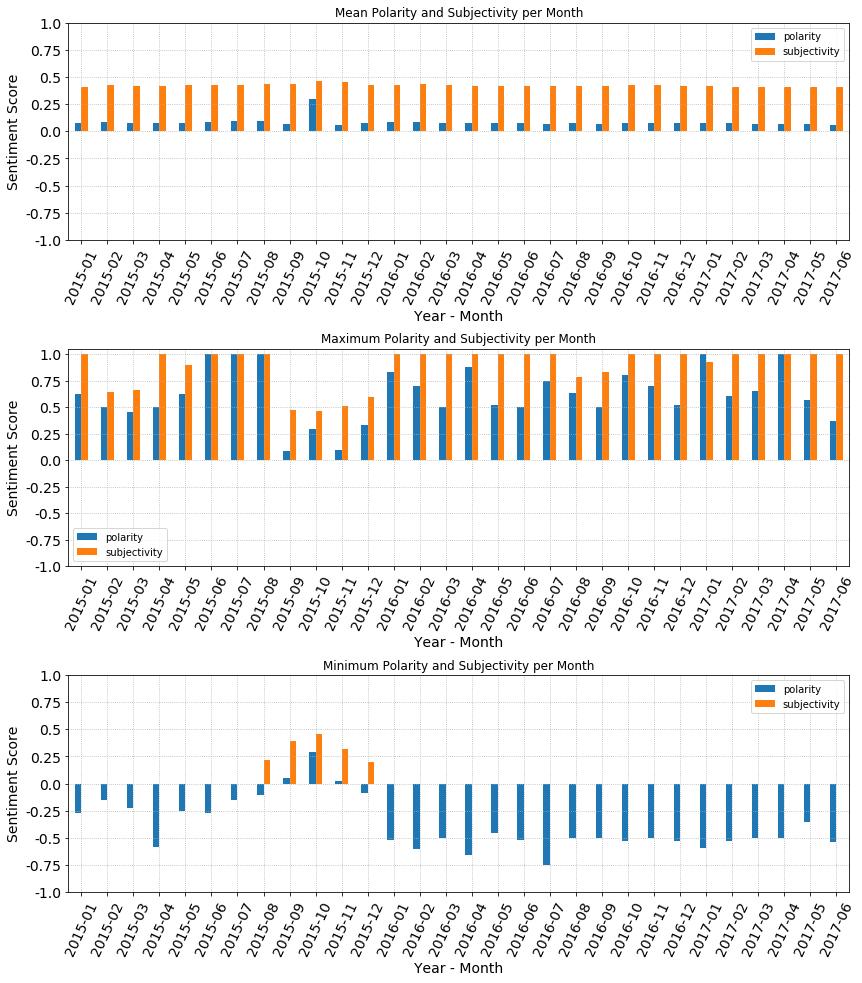

In [370]:
sentiment_group = tfidf_sentiment_df.drop(columns=['title', 'year', 'month', 'day', 'tdidf']) \
                                    .groupby(['YYYY_MM'])
sentiment_mean = sentiment_group.mean().sort_index()
sentiment_max = sentiment_group.max().sort_index()
sentiment_min = sentiment_group.min().sort_index()

fig, axes = plt.subplots(nrows=4, ncols=1, sharex=False, sharey=False)
fig.set_size_inches(14, 16)
fig.subplots_adjust(hspace=.5)

yticks = [x / 100 for x in range(-100, 110, 25)]
yticklabels = [str(ytick) for ytick in yticks]

sentiment_mean_plot_args = {
    'kind' : 'bar',
    'fontsize' : 14,
    'title' : 'Mean Polarity and Subjectivity per Month',
    'ax' : axes[0],
    'rot' : 65,
    'y' : list(sentiment_mean.columns.values)
}

sentiment_max_plot_args = {
    'kind' : 'bar',
    'fontsize' : 14,
    'title' : 'Maximum Polarity and Subjectivity per Month',
    'ax' : axes[1],
    'rot' : 65,
    'y' : list(sentiment_max.columns.values)
}

sentiment_min_plot_args = {
    'kind' : 'bar',
    'fontsize' : 14,
    'title' : 'Minimum Polarity and Subjectivity per Month',
    'ax' : axes[2],
    'rot' : 65,
    'y' : list(sentiment_min.columns.values)
}

sentiment_mean_plot = sentiment_mean.plot(**sentiment_mean_plot_args)
sentiment_mean_plot.set_xlabel('Year - Month', fontsize=14)
sentiment_mean_plot.set_ylabel('Sentiment Score', fontsize=14)
sentiment_mean_plot.set_yticks(yticks)
sentiment_mean_plot.set_yticklabels(yticklabels, fontsize=14)
sentiment_mean_plot.grid('on', which='both', linestyle=':')

sentiment_max_plot = sentiment_max.plot(**sentiment_max_plot_args)
sentiment_max_plot.set_xlabel('Year - Month', fontsize=14)
sentiment_max_plot.set_ylabel('Sentiment Score', fontsize=14)
sentiment_max_plot.set_yticks(yticks)
sentiment_max_plot.set_yticklabels(yticklabels, fontsize=14)
sentiment_max_plot.grid('on', which='both', linestyle=':')

sentiment_min_plot = sentiment_min.plot(**sentiment_min_plot_args)
sentiment_min_plot.set_xlabel('Year - Month', fontsize=14)
sentiment_min_plot.set_ylabel('Sentiment Score', fontsize=14)
sentiment_min_plot.set_yticks(yticks)
sentiment_min_plot.set_yticklabels(yticklabels, fontsize=14)
sentiment_min_plot.grid('on', which='both', linestyle=':')

## Cosine Similarity of News Articles' TFIDF

### Details of Cosine Similarity Analysis Step

##### Global Vectors (GloVe) for Word Representation
We choose a few keywords that relate to the company or type of companies we are trying to predict the stock of. In our project, we use a list of keywords that most closely describe technology companies. The keywords that we've chosen for this project are ('technology', 'phone', 'internet', 'security'). We create the word vector representation of these keywords and use this to find the cosine simliarity of the keywords to the vector representation of the TFIDFs that we've calculated.
<br>
<br>
We calculate the cosine similarity of the words taken from each article from the previous Sentiment-TFIDF step. This allows us to find the most related articles to our keywords vector.

##### Source
We utilized the 300 dimension word vectors from https://nlp.stanford.edu/data/ to calculate our cosine similarities. GloVe is an unsupervised machine learning algorithm for obtaining vector representations for words. GloVe was developed at Stanford as an open source project.

##### Functions used to calculate cosine similarity
We also created a class called CosineSimilarity that holds the functions needed to calculate cosine similaritis of individual words as well as lists of words.

In [42]:
import os
import re
import math
import csv
import json
import pandas as pd
import pyspark
from pyspark import SparkContext
from glob import glob
import json
import nltk

In [43]:
class CosineSimilarity:

    def __init__(self, dim, glove_path=None):
        self.dim = dim
        self.df = None
        self.loadVectors(glove_path)

    def loadVectors(self, glove_path):
        """Loads in the glove vectors

        Args:
            glove_path (path): path to glove vectors file
        """
        if glove_path and os.path.exists(glove_path):
            self.df = pd.read_csv(glove_path,
                                header=None,
                                sep=' ',
                                quoting=csv.QUOTE_NONE
                                ).set_index(0)

    def cosine(self, A, B):
        """Computes the cosine similarity of vectors A and B

        Args:
            A (np.array): array 1
            B (np.array): array 2

        Returns:
            float : Cosine similarity of vectors A and B
        """

        dot_prod = sum(A * B)
        mag_A    = sqrt(sum(A * A))
        mag_B    = sqrt(sum(B * B))

        return dot_prod / (mag_A * mag_B)

    def sentence_to_vec(self, tokens):
        """Creates word vector from sentence

        Args:
            tokens (list(str)): list of tokens

        Returns:
            np.array: vector representation of tokens
        """
        if len(tokens) == 0:
            return None

        # step 1: lower all words
        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()

        """
        step 2-3: look up word vectors for each token,
        compute the component-wise sum of the
        word vectors , and divide by num words
        """
        vec = np.zeros(self.dim)
        for token in tokens:
            try:
                vec += self.df.loc[token]
            except KeyError:
                pass

        vec /= len(tokens)

        return vec

    def cosFromWord(self, df, word):
        """Compute cosine similarities of words in df to word

        Args:
            df (pandas.DataFrame): DataFrame of words and their vectors
            word (str): word to find similarity of

        Returns:
            pandas.DataFrame: words in df and their cosine similarity to word
        """
        myvec     = array(df.loc[word])
        words     = df.index
        cos_words = list()
        for i in range(len(df)):
            # acquire the vector representation of the word
            vec = array(df.iloc[i])
            # calculate the cosine similarity
            cos_sim = self.cosine(myvec, vec)
            # append the cosine similarity of the word and the word siteself to the list
            cos_words.append([cos_sim, words[i]])

        # Transform the sorted_cos_words list to put it in the dataframe
        sorted_cos_words = sorted(cos_words)
        sorted_cos_words.reverse()
        sorted_cos_words = np.array(sorted_cos_words)
        sorted_cos_words = np.transpose(sorted_cos_words)

        # Create the dataframe
        cos_words_df = pd.DataFrame({
            'Cosine Similarity' : sorted_cos_words[0],
            'Word'              : sorted_cos_words[1]
        })

        return cos_words_df

    def cosFromVec(self, df, myvec):
        """Finds cosine similarity of words in df to myvec

        Args:
            df (pandas.DataFrame): DataFrame of words and their vectors
            myvec (np.array): vector to find similarity of

        Returns:
            pandas.DataFrame: words in df and their cosine similarity to myvec
        """
        words = df.index
        cos_words = list()
        for i in range(len(df)):
            # acquire the vector representation of the word
            vec = array(df.iloc[i])
            # calculate the cosine similarity
            cos_sim = cosine(myvec, vec)
            # append the cosine similarity of the word and the word siteself to the list
            cos_words.append([cos_sim, words[i]])

        # Transform the sorted_cos_words list to put it in the dataframe
        sorted_cos_words = sorted(cos_words)
        sorted_cos_words.reverse()
        sorted_cos_words = np.array(sorted_cos_words)
        sorted_cos_words = np.transpose(sorted_cos_words)
        # Create the dataframe
        cos_words_df = pd.DataFrame({
            'Cosine Similarity' :sorted_cos_words[0],
            'Word'              :sorted_cos_words[1]
        })

        return cos_words_df

In [44]:
def cosine_similarity_news_artiles(args):
    tokens, cos_sim, input_folder, output_folder, articles_name = args

    articles_path = os.path.join(input_folder, articles_name)
    output_path = os.path.join(output_folder, articles_name.replace('.json', '.csv'))

#     print('Analyzing {}'.format(articles_path))

    month_df = pd.DataFrame(columns=['date', 'year', 'month',
                                     'day', 'title',
                                     'polarity', 'subjectivity',
                                     'relatedness_title',
                                     'relatedness_content'])

    with open(articles_path) as f:
        try:
            month = json.load(f)
            month['data'].sort(key=lambda datum: datum['day'])
        except Exception:
            month_df.to_csv(output_path, index=False)
            print('Error in from {}'.format(articles_path))
            return

    vector_compare = cos_sim.sentence_to_vec(tokens)

    for data in month['data']:

        # Get list of tokens for tdidf and title
        tokens_tdidf = [tdidfs[0] for tdidfs in data['tdidf']]
        tokens_title = nltk.word_tokenize(data['title'])

        try:
            vector_tdidf = cos_sim.sentence_to_vec(tokens_tdidf)
            cos_title = cos_sim.cosine(vector_tdidf, vector_compare)
        except Exception:
            cos_title = 0.0

        try:
            vector_title = cos_sim.sentence_to_vec(tokens_title)
            cos_tdidf = cos_sim.cosine(vector_title, vector_compare)
        except Exception:
            cos_tdidf = 0.0

        day_data = {
            'date'                : ['{Y}-{M:02}-{D:02}'.format(Y=int(data['year']), M=int(data['month']), D=int(data['day']))],
            'year'                : [data['year']],
            'month'               : [data['month']],
            'day'                 : [data['day']],
            'title'               : [data['title']],
            'subjectivity'        : [data['subjectivity']],
            'polarity'            : [data['polarity']],
            'relatedness_title'   : [cos_title],
            'relatedness_content' : [cos_tdidf]
        }
        day_df = pd.DataFrame.from_dict(day_data)
        month_df = month_df.append(day_df)

    month_df = month_df.reset_index(drop=True)
    month_df.to_csv(output_path, index=False)

#     print('Finished analyzing {} with {} results'.format(articles_path, len(month_df)))
#     print(output_path)
    return

In [372]:
input_folder = 'data/tfidf/all-the-news/'
dim = 300
output_folder = 'data/cosineSimilarity/all-the-news/dim{dim}_1'.format(dim=dim)
vector_model_path = 'glove.6B/glove.6B.{dim}d.txt'.format(dim=dim)

try:
    os.mkdirs(input_folder, exist_ok=True)
except:
    pass

try:
    os.mkdir(output_folder)
except:
    pass

articles_names = glob(os.path.join(input_folder, 'articles_2016*'))

In [373]:
tokens = ['technology', 'phone', 'internet', 'security']
cos_sim = CosineSimilarity(dim, glove_path=vector_model_path)

arguments = [(tokens, cos_sim, input_folder, 
              output_folder, os.path.basename(articles_name)) for articles_name in articles_names]

In [47]:
print('Starting analysis')
sc = pyspark.SparkContext(appName='News Articles')
process_cosine_by_month = sc.parallelize(arguments, len(arguments)).map(cosine_similarity_news_artiles)
collect_cosine_by_month = process_cosine_by_month.collect()
sc.stop()
print('Finished analysis')

Starting analysis
Finished analysis


## FInal Preprocessing Step: Daily Max Cosine Similarity

### Details of Analysis Step

In [48]:
import os
import math
import pandas as pd
from glob import glob

In [49]:
input_folder = 'data/cosineSimilarity/all-the-news/dim300_1'
Y = '2016'
M = '*'

regex_names = 'articles_{Y}_{M}.csv'.format(Y=Y, M=M)
regex_paths = os.path.join(input_folder, regex_names)

articles_names = glob(regex_paths)

output_name = 'max_articles_{Y}_1.csv'.format(Y=Y)
output_path = os.path.join(input_folder, output_name)

In [52]:
max_df = pd.DataFrame(columns=['date', 'year', 'month',
                           'day', 'title',
                           'polarity', 'subjectivity',
                           'relatedness_title',
                           'relatedness_content'])

for articles_name in articles_names:
    
    month_df = pd.read_csv(articles_name)

    for day in range(1, 31+1):
        day_df = month_df.where((month_df.day == day)).dropna().reset_index(drop=True)

        max_day_df = day_df.sort_values('relatedness_content', ascending=False).drop_duplicates('month')

        max_df = max_df.append(max_day_df)
        
max_df = max_df.reset_index(drop=True)
max_df.to_csv(output_path, index=False)

In [53]:
max_df.head(5)

,date,day,month,polarity,relatedness_content,relatedness_title,subjectivity,title,year
0,2016-04-01,1.0,4.0,0.085107,0.602862,0.634297,0.228841,White House Blames ‘Technical Issue’ for Video...,2016.0
1,2016-04-02,2.0,4.0,0.000000,0.626780,0.612029,0.066667,"REPORT: SunEdison, the solar company that has ...",2016.0
2,2016-04-03,3.0,4.0,0.063604,0.632537,0.755229,0.429297,The FBI’s method for breaking into a locked iP...,2016.0
3,2016-04-04,4.0,4.0,0.126843,0.671355,0.653776,0.396793,Microsoft CEO: The secret to a harmonious life...,2016.0
4,2016-04-05,5.0,4.0,0.094392,0.607089,0.522723,0.357644,Tech Company Invites U.S. Workers Who Fear Tru...,2016.0
